In [1]:
%%capture
!pip install scikeras
!pip install shap
!pip install lime

In [2]:
#data manipulation libraries
import pandas as pd
import numpy as np

#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#sklearn machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
#deep learning libraries
import tensorflow as tf

#keras wrapper
from scikeras.wrappers import KerasClassifier

#XAI
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap

#initialize shap
shap.initjs()

#set seed for reproducibility
seed = 60
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#load the data
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")
PID = testdf["PassengerId"]

In [4]:
#display training data
traindf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#display testing data
testdf.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
#display general information
traindf.info()
print("-"*40)
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [7]:
#distribution of numerical features
traindf.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
#distirbution of non-numerical features
traindf.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [9]:
#explore rows with missing embarked location
traindf[traindf['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [10]:
#fill missing embarked locations based on name origin
traindf.at[61, "Embarked"] = "C"
traindf.at[829, "Embarked"] = "S"

#convert 'Embarked' into numerical value
traindf["Embarked"] = traindf["Embarked"].map({"S":0,"C":1,"Q":2}).astype(int)
testdf["Embarked"] = testdf["Embarked"].map({"S":0,"C":1,"Q":2}).astype(int)

In [11]:
#extract title from the 'Name' column
traindf["Title"] = traindf.Name.str.split(", ").str[1]
traindf["Title"] = traindf.Title.str.split(".").str[0]

testdf["Title"] = testdf.Name.str.split(", ").str[1]
testdf["Title"] = testdf.Title.str.split(".").str[0]

In [12]:
#unique train titles
trainTitles = traindf["Title"].value_counts()
trainTitles = pd.DataFrame({"Title":trainTitles.index,"Count":trainTitles.values})
trainTitles

,Title,Count
0,Mr,517
1,Miss,182
2,Mrs,125
3,Master,40
4,Dr,7
5,Rev,6
6,Mlle,2
7,Major,2
8,Col,2
9,the Countess,1


In [13]:
#unique test titles
testTitles = testdf["Title"].value_counts()
testTitles = pd.DataFrame({"Title":testTitles.index,"Count":testTitles.values})
testTitles

,Title,Count
0,Mr,240
1,Miss,78
2,Mrs,72
3,Master,21
4,Col,2
5,Rev,2
6,Ms,1
7,Dr,1
8,Dona,1


In [14]:
#convert title into a numerical value
traindf["Title"] = traindf["Title"].replace(["Don","Rev","Dr","Major","Lady","Sir","Col","Capt","the Countess","Jonkheer"],"Rare")
traindf["Title"] = traindf["Title"].replace("Mme","Mrs")
traindf["Title"] = traindf["Title"].replace("Ms","Miss")
traindf["Title"] = traindf["Title"].replace("Mlle","Miss")
traindf["Title"] = traindf["Title"].map({"Mr":0,"Miss":1,"Mrs":2,"Master":3,"Rare":4}).astype(int)

testdf["Title"] = testdf["Title"].replace(["Col","Rev","Dr","Dona"],"Rare")
testdf["Title"] = testdf["Title"].replace("Ms","Miss")
testdf["Title"] = testdf["Title"].map({"Mr":0,"Miss":1,"Mrs":2,"Master":3,"Rare":4}).astype(int)

In [15]:
#convert 'Sex' into a numerical value
traindf["Sex"] = traindf["Sex"].map({"female":1,"male":0}).astype(int)
testdf["Sex"] = testdf["Sex"].map({"female":1,"male":0}).astype(int)

In [16]:
#extract decks from the cabin column (N for No cabin)
traindf["Cabin"] = traindf["Cabin"].fillna("N")
traindf["Deck"] = traindf["Cabin"].str[0]

testdf["Cabin"] = testdf["Cabin"].fillna("N")
testdf["Deck"] = testdf["Cabin"].str[0]

In [17]:
#unique train decks
trainDeck = traindf["Deck"].value_counts()
trainDeck = pd.DataFrame({"Deck":trainDeck.index,"Count":trainDeck.values})
trainDeck

,Deck,Count
0,N,687
1,C,59
2,B,47
3,D,33
4,E,32
5,A,15
6,F,13
7,G,4
8,T,1


In [18]:
#unique test decks
testDeck = testdf["Deck"].value_counts()
testDeck = pd.DataFrame({"Deck":testDeck.index,"Count":testDeck.values})
testDeck

,Deck,Count
0,N,327
1,C,35
2,B,18
3,D,13
4,E,9
5,F,8
6,A,7
7,G,1


In [19]:
#convert 'Deck' into numerical values
traindf["Deck"] = traindf["Deck"].map({"N":0,"C":1,"B":2,"D":3,"E":4,"A":5,"F":6,"G":7,"T":5}).astype(int) #note T:5, as T and A are the most similar
testdf["Deck"] = testdf["Deck"].map({"N":0,"C":1,"B":2,"D":3,"E":4,"A":5,"F":6,"G":7}).astype(int)

In [20]:
#adjust values in 'Pclass'
traindf["Pclass"] = traindf["Pclass"] - 1
testdf["Pclass"] = testdf["Pclass"] - 1

#drop columns that are unrelated to the survival
traindf.drop(["Name","PassengerId","Cabin","Ticket"],axis=1,inplace=True)
testdf.drop(["Name","PassengerId","Cabin","Ticket"],axis=1,inplace=True)

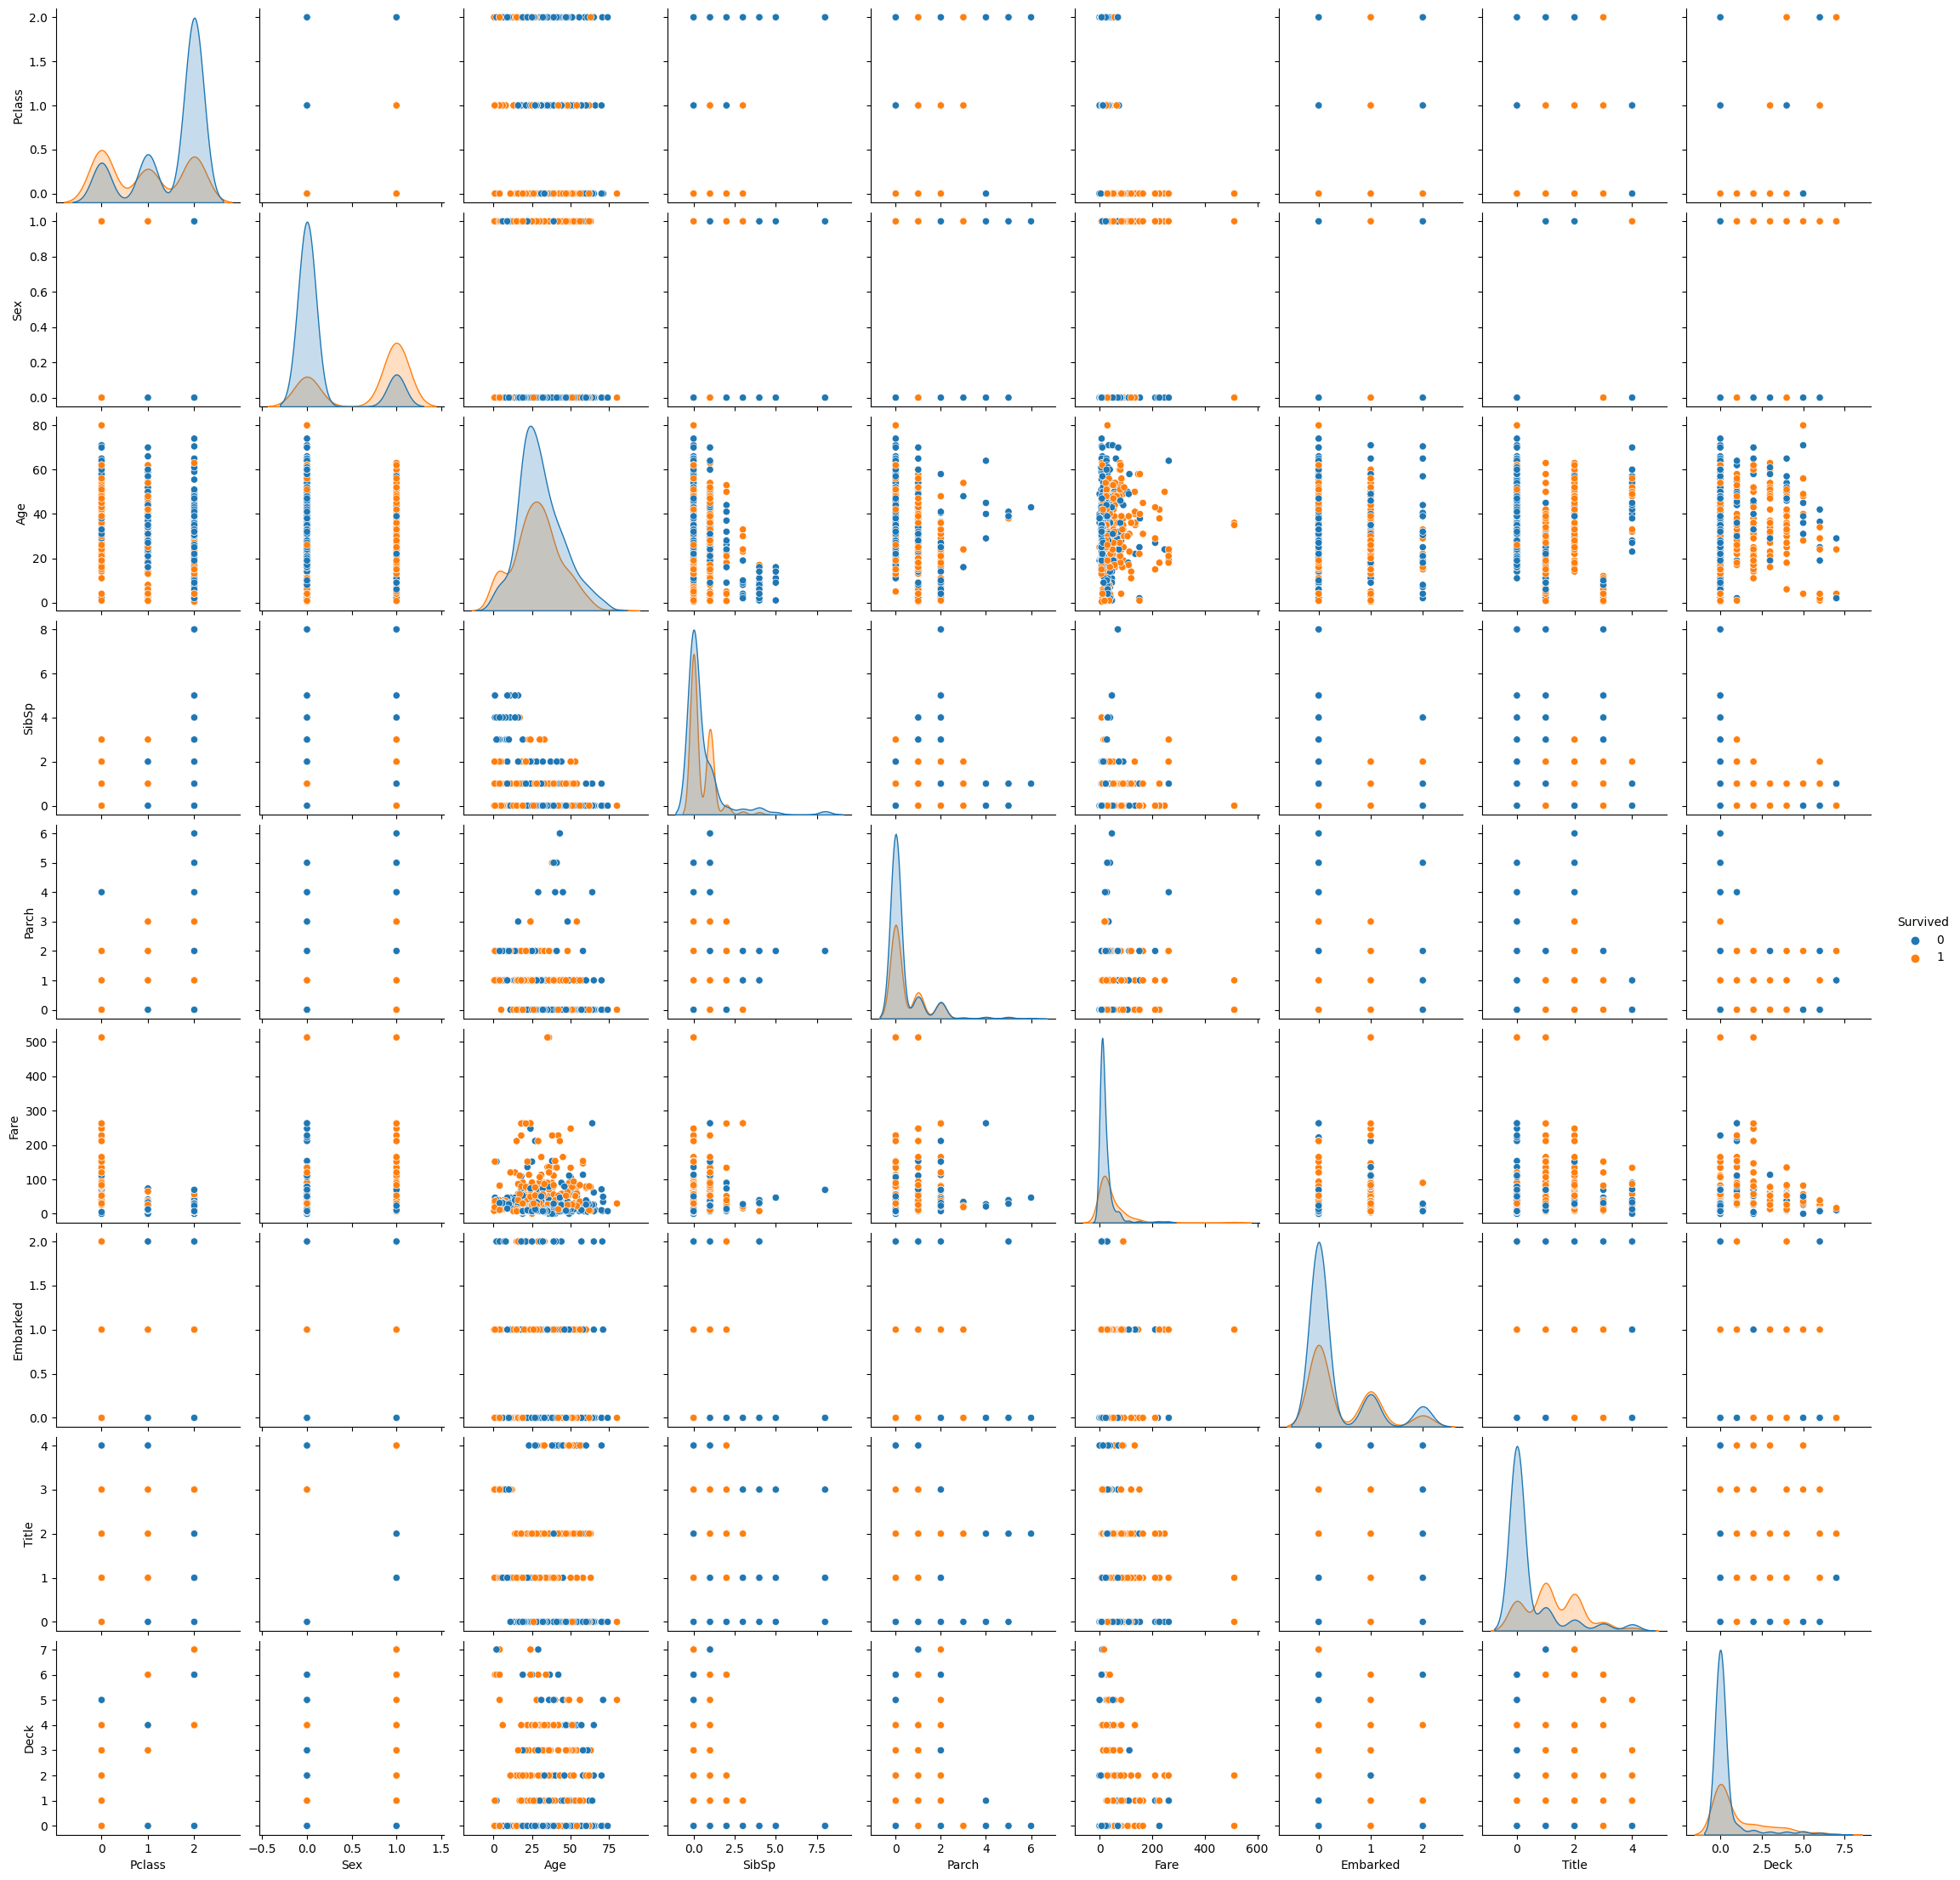

In [21]:
#correlation plots
sns.pairplot(traindf,hue="Survived");

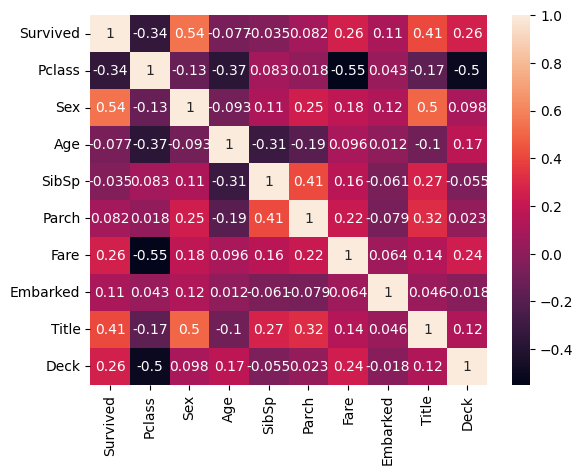

In [22]:
#correlation heatmap
sns.heatmap(traindf.corr(numeric_only=True),annot=True);

In [23]:
#fill in 'Age' with the median
traindf["Age"].fillna(traindf["Age"].median(skipna=True),inplace=True)
testdf["Age"].fillna(traindf["Age"].median(skipna=True),inplace=True)

#fill in 'Fare' with the median
testdf["Fare"].fillna(traindf["Fare"].median(skipna=True),inplace=True)

In [24]:
#one hot encoding
traindf = pd.get_dummies(traindf,columns=["Title","Embarked","Deck","Pclass","Sex"])
testdf = pd.get_dummies(testdf,columns=["Title","Embarked","Deck","Pclass","Sex"])

In [25]:
#scaling continuous variables
scaler = StandardScaler()
col = ["Age","Fare"]
scaler.fit(traindf[col])
traindf[col] = scaler.transform(traindf[col])
testdf[col] = scaler.transform(testdf[col])

In [26]:
#check the pre-processed training data
traindf.head()

,Survived,Age,SibSp,Parch,Fare,Title_0,Title_1,Title_2,Title_3,Title_4,...,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Pclass_0,Pclass_1,Pclass_2,Sex_0,Sex_1
0,0,-0.565736,1,0,-0.502445,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,1,0.663861,1,0,0.786845,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
2,1,-0.258337,0,0,-0.488854,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1,0.433312,1,0,0.420730,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,0.433312,0,0,-0.486337,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [27]:
#check the pre-processed test data
testdf.head()

,Age,SibSp,Parch,Fare,Title_0,Title_1,Title_2,Title_3,Title_4,Embarked_0,...,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Pclass_0,Pclass_1,Pclass_2,Sex_0,Sex_1
0,0.394887,0,0,-0.490783,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,1.355510,1,0,-0.507479,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,2.508257,0,0,-0.453367,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,-0.181487,0,0,-0.474005,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
4,-0.565736,1,1,-0.401017,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1


In [28]:
#split the dataset into training and testing sets
X_train = traindf.drop("Survived",axis=1)
y_train = traindf["Survived"]
X_test  = testdf

#setup kfold for cross-validation
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

In [29]:
%%capture
#Logistic regression

#setup parameters to try
lrParam = {
    "penalty":["l1","l2","elasticnet",None],
    "C":[0.001,0.01,0.1,1,10,100],
    "solver":["newton-cg","lbfgs","liblinear","sag","saga"],
    "max_iter":[100,500,1000,5000]
    }

#setup the grid search object
lrGS = GridSearchCV(LogisticRegression(random_state=seed),lrParam,n_jobs=-1,verbose=0,cv=skf)

#fit the data
lrGS.fit(X_train,y_train)

#create a Logistic Regression model with optimal parameters
lr = LogisticRegression(**lrGS.best_params_,random_state=seed)

#fit the training data to the model
lr.fit(X_train,y_train)

#predict the classes of the test set
lrPred = lr.predict(X_test)

In [30]:
%%capture
#explain survivors with SHAP
explainer = shap.SamplingExplainer(lr.predict, X_train)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


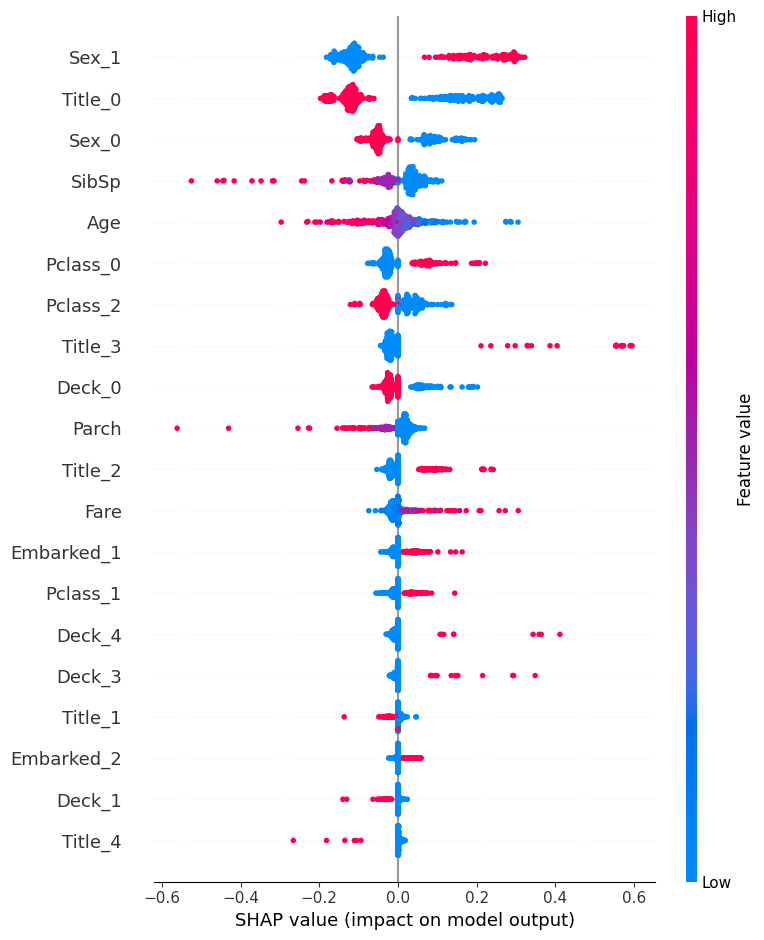

In [31]:
shap.summary_plot(shap_values, X_test)

In [32]:
#Random forest

#setup parameters to try
rfParam = {
    "n_estimators": [50, 100, 150],
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False],
}

#setup the grid search object
rfGS = GridSearchCV(RandomForestClassifier(random_state=seed),rfParam,n_jobs=-1,cv=skf)

#fit the data
rfGS.fit(X_train,y_train)

#create a Random Forest Classifier with the best parameters
rfc = RandomForestClassifier(**rfGS.best_params_,random_state=seed)

#train the classifier on the training data
rfc.fit(X_train,y_train)

#predict the classes of the test set
rfcPred = rfc.predict(X_test)

In [33]:
#explain survivors with SHAP
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


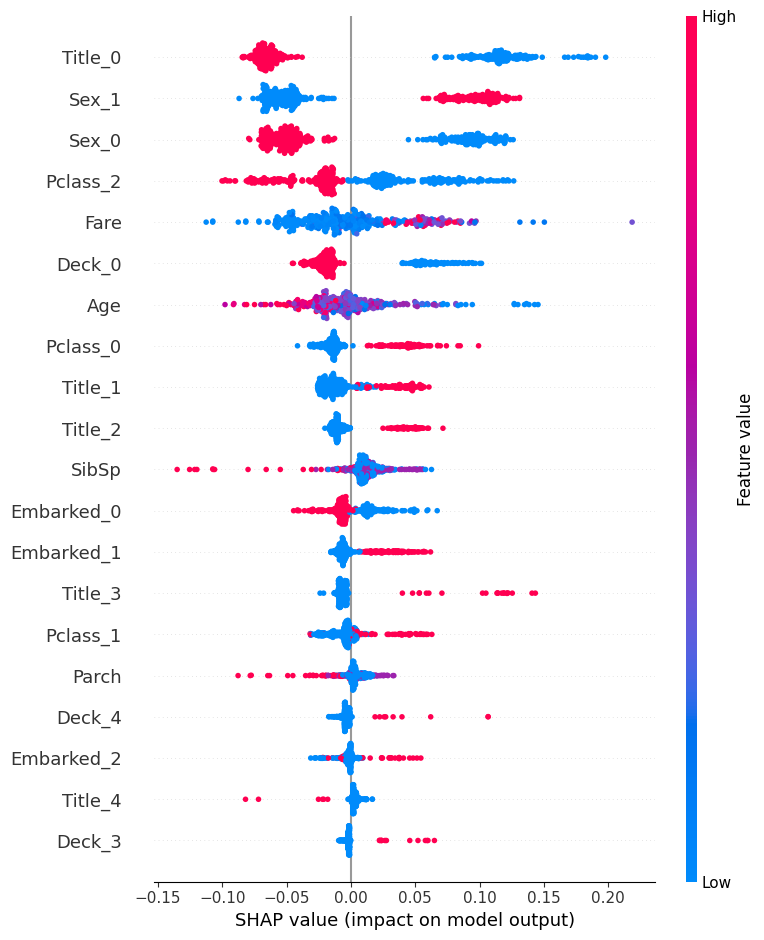

In [34]:
shap.summary_plot(shap_values[1], X_test)

In [35]:
#Deep neural network

#setup parameters to try
dnnParam = {
    "hidden_layers": [1,2,3,4],
    "neurons": [16,32,64],
    "activation": ["relu","tanh"],
    "optimizer": ["adam","rmsprop"]
}

#set up model creation for grid search
def createDNN(hidden_layers=1,neurons=32,activation="relu",optimizer="adam"):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neurons, activation="relu", input_shape=(X_train.shape[1],)))
    
    for i in range(hidden_layers):
        model.add(tf.keras.layers.Dense(neurons, activation=activation))
    
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

#wrap the model and initialize values
kc = KerasClassifier(model=createDNN,hidden_layers=1,neurons=32,activation="relu",optimizer="adam", epochs=10, batch_size=32, verbose=0)

#perform grid search
dnnGS = GridSearchCV(kc, param_grid=dnnParam, cv=3)
dnnGS.fit(X_train, y_train)

#create new model with the best parameters
dnn = createDNN(**dnnGS.best_params_)

#fit the data to the model
dnn.fit(X_train,y_train,verbose=0,epochs=100,batch_size=32)

#predict the classes of the test set
predictions = (dnn.predict(X_test) > 0.5).astype(int)

14/14 [==============================] - 0s 1ms/step


In [36]:
%%capture
#explain survivors with SHAP
explainer = shap.SamplingExplainer(dnn.predict, X_train)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


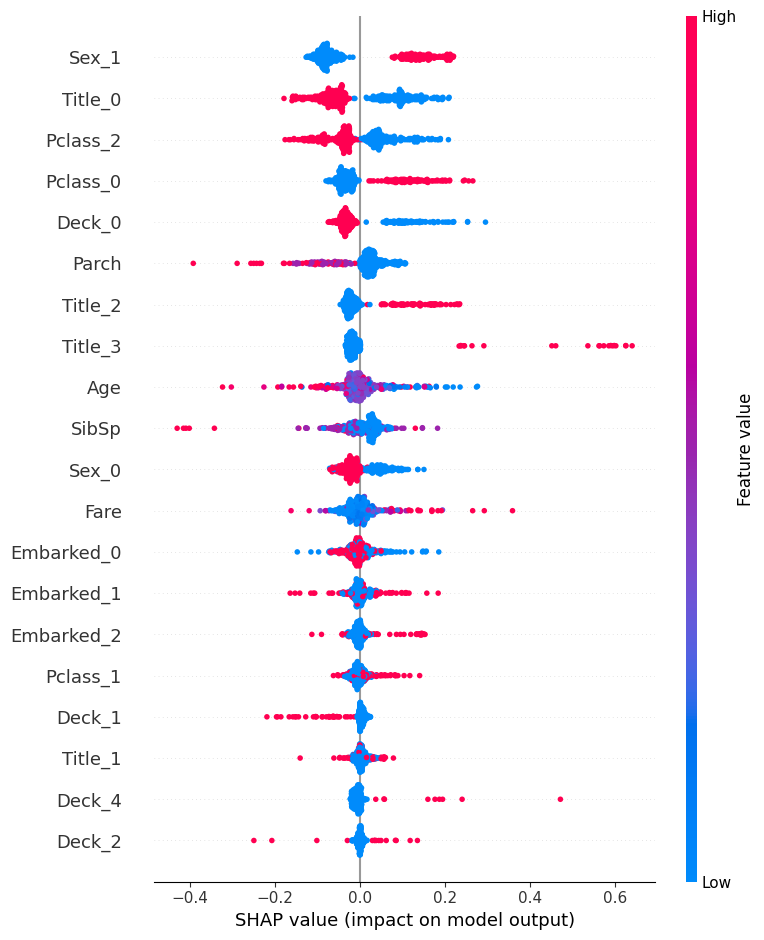

In [37]:
shap.summary_plot(shap_values, X_test)

In [38]:
#Shallow neural network

#setup parameters to try
mlpParam = {
    "hidden_layer_sizes": [(10,), (50,), (100,), (10,10,), (50,50,), (100,100,)],
    "activation": ["logistic", "tanh", "relu"],
    "solver": ["adam"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ["constant", "adaptive"],
    "batch_size": [32, 64],
    "early_stopping": [True]
}

#perform grid search
mlpGS = GridSearchCV(MLPClassifier(max_iter=1000,random_state=seed),param_grid=mlpParam, verbose=0, n_jobs=-1,cv=skf)
mlpGS.fit(X_train,y_train)

#create a neural network with othe best parameters
mlp = MLPClassifier(max_iter=1000,random_state=seed,**mlpGS.best_params_)

#train the model on the input data and output labels
mlp.fit(X_train, y_train)

#make predictions on new data
mlpPred = mlp.predict(X_test)

In [39]:
%%capture
#explain survivors with SHAP
explainer = shap.SamplingExplainer(mlp.predict, X_train)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


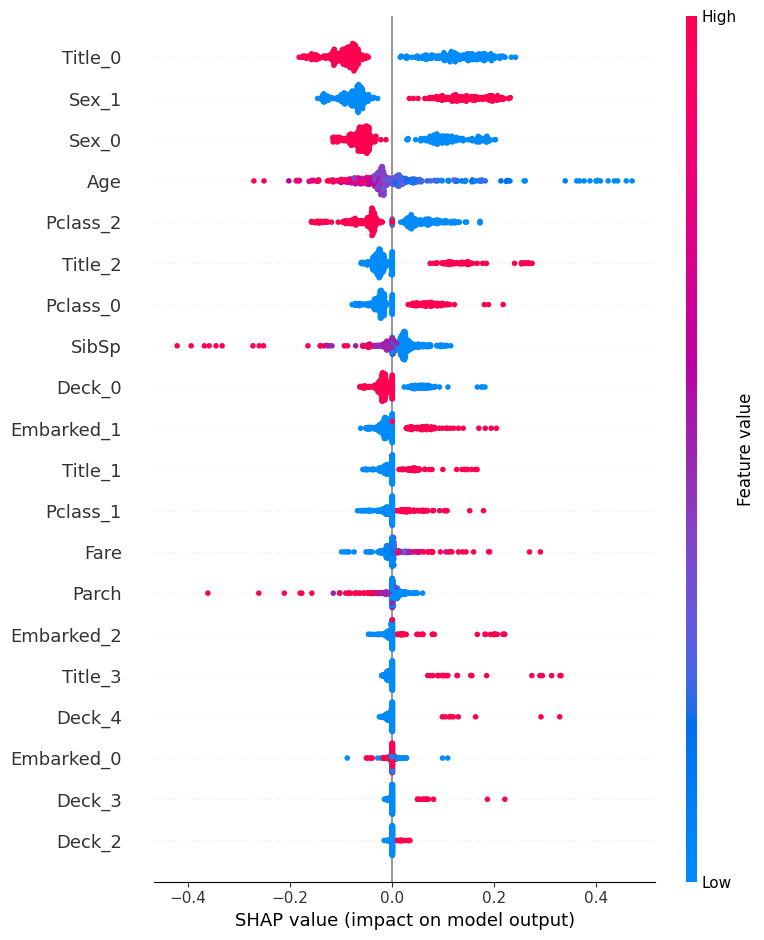

In [40]:
shap.summary_plot(shap_values, X_test)

In [41]:
#accuracy scores
print("Accuracy score for Logistic Regression:", lrGS.best_score_)
print("Accuracy score for Random Forest:", rfGS.best_score_)
print("Accuracy score for Deep Neural Network:", dnnGS.best_score_)
print("Accuracy score for Shallow Neural Network", mlpGS.best_score_)

Accuracy score for Logistic Regression: 0.8338961772644531
Accuracy score for Random Forest: 0.8507438327788588
Accuracy score for Deep Neural Network: 0.8395061728395062
Accuracy score for Shallow Neural Network 0.8338836231247255
